<a href="https://colab.research.google.com/github/zdzichumis/Object-tracking-code/blob/main/Analiza%20wynik%C3%B3w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [ ]:
def check_if_inside(point, bbox):
    bx0, by0, bx1, by1 = bbox
    x, y = point
    return (bx0 <= x <= bx1) and (by0 <= y <= by1)

In [ ]:
tracking_bbox = pd.read_csv("track_04_30_18h_18.csv")
#true_points = pd.read_csv("tagged2min_04_30_18h_18.csv")
true_points = pd.read_csv("interpolated2min_04_30_18h_18.csv")


## ograniczanie danych

#### do obszaru zainteresowania na czerwono

In [ ]:
main_area = [(0,720), (75, 288), (166,243), (1015,200), (1082, 241),
(1207, 512), (1065, 720)]
top_area = [(972, 390), (710, 310), (1135, 116), (1205, 161)]
bottom_area = [(1,661),(377,450),(807, 589),(640,719), (0,720)]
left_area = [(397,450),(591,337), (0,149), (1,293)]
right_area = [(755,598),(971,390), (1270, 505), (1259,684)]

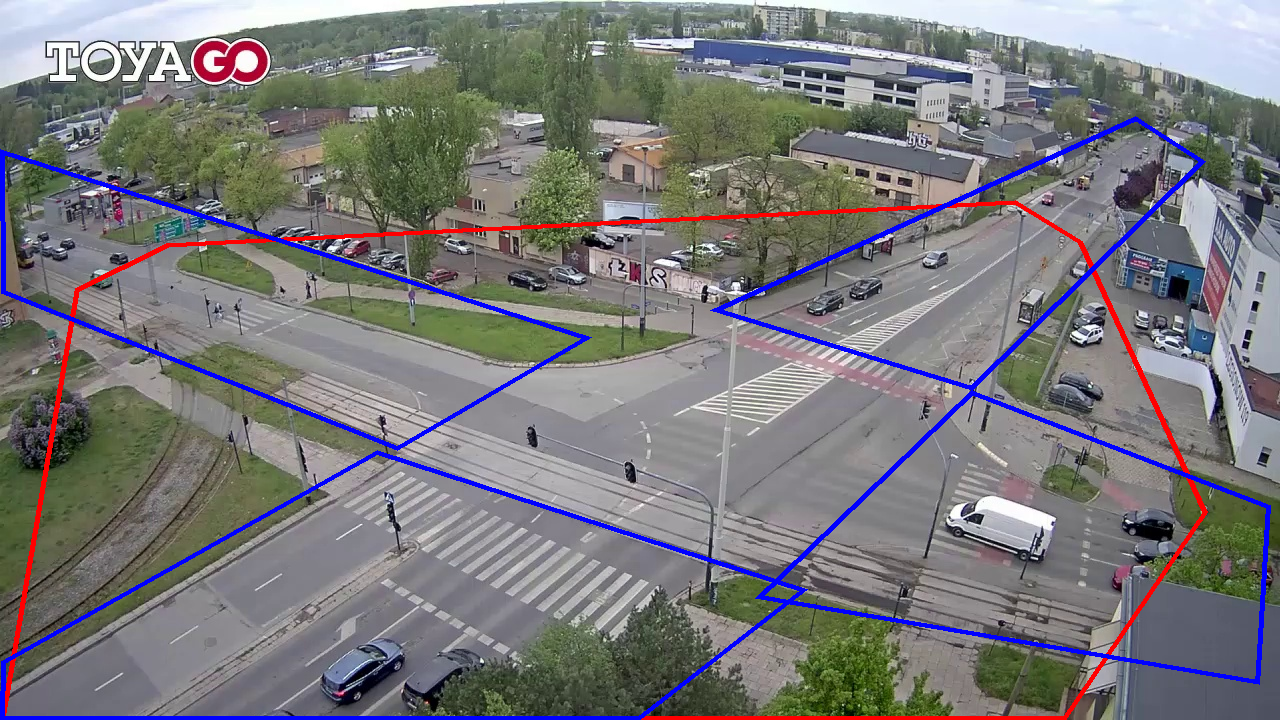

In [ ]:
img = Image.open("reference.jpg")
img1 = ImageDraw.Draw(img)
img1.polygon(main_area, outline ="red", width=5)
img1.polygon(bottom_area, outline ="blue", width=5)
img1.polygon(top_area, outline ="blue", width=5)
img1.polygon(left_area, outline ="blue", width=5)
img1.polygon(right_area, outline ="blue", width=5)
img

$$ta+(1-t)b = (c_x, \cdot)$$

$$b+t(a-b) = (c_x, \cdot)$$

$$t^\ast = \frac{c_x-b_x}{a_x-b_x}, \ t^\ast(a-b) + b > c_y$$

In [ ]:
def is_inner(px,py, polygon=main_area, verbose=False):
    points = polygon + [polygon[0]]
    counter = 0
    for a,b in zip(points, points[1:]):
        ax, ay = a
        bx, by = b
        ax, ay, bx, by = ax + 0.1, ay + 0.1, bx + 0.1, by + 0.1
        t = (px - bx)/(ax - bx)
        if 0 <= t < 1 and t * (ay - by) + by >= py:
            counter += 1
        if verbose:
            print(a, b, t)
    if verbose:
        print(counter)
    return (counter % 2) != 0


In [ ]:
#####
#####  TAKES TRUE POINTS ONLY FROM INSIDE THE AREA OF INTEREST
#####

true_points = true_points[true_points.apply(lambda row: is_inner(row["x"], row["y"]), axis=1)]

#### do pierwszych dwóch minut

In [ ]:
#####
#####  TAKES ONLY FRAMES FROM THE FIRST TWO MINUTES
#####

true_points = true_points[true_points["frame"] <= 30*60*2]
tracking_bbox = tracking_bbox[tracking_bbox["frame"] <= 30*60*2]

## Dodanie informacji o kierunku ruchu

 BRAK JESZCZE INFORMACJI O ZWROCIE, czyli do `BL` zaliczam samochody jadące z dołu w lewo, albo jadące z lewej strony w dół.

In [ ]:
directions = []
for label, data in true_points.groupby("label"):
    for name, area in [("L", left_area), ("R", right_area), ("B", bottom_area), ("T", top_area)]:
        data[f"{name}"] = data.apply(lambda row: is_inner(row["x"], row["y"], area), axis=1)
    path_type = "".join([t for t, b in data[["L","R","B","T"]].any().items() if b])
    directions.append((label, path_type))
directions = pd.DataFrame(directions, columns = ["label", "path type"])

In [ ]:
directions["path type"].value_counts()

BT    16
LB    12
LR     9
B      3
LT     3
RT     1
RB     1
L      1
R      1
Name: path type, dtype: int64

In [ ]:
true_points = pd.merge(directions, true_points, on="label")

In [ ]:
true_points

,label,path type,x,y,frame
0,0,BT,962,261,0
1,0,BT,949,269,15
2,0,BT,931,278,30
3,0,BT,917,284,45
4,0,BT,903,290,60
...,...,...,...,...,...
40746,46,B,237,688,3595
40747,46,B,237,688,3596
40748,46,B,237,688,3597
40749,46,B,237,688,3598


### sprawdzenie jak wyglądają typy trajektorii

In [ ]:
def check_path(points):
    plt.title("true points")
    plt.scatter(points["x"], (-1)*points["y"], s=1)
    for polygon in [left_area, right_area, bottom_area, top_area]:
        area = np.array(polygon + [polygon[0]])
        plt.plot(area[:, 0], -area[:, 1], color="green")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)

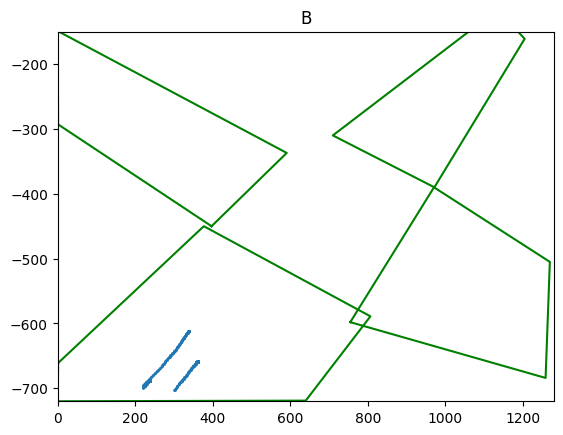

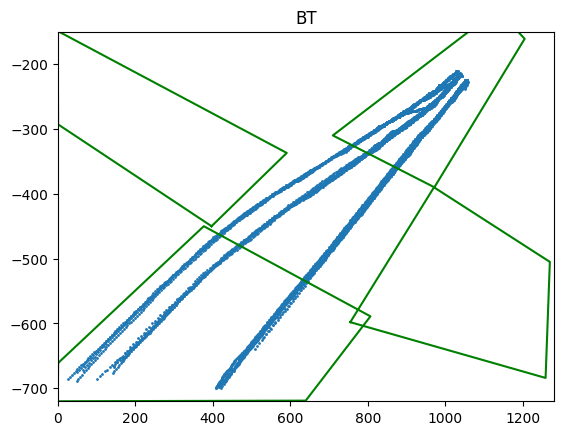

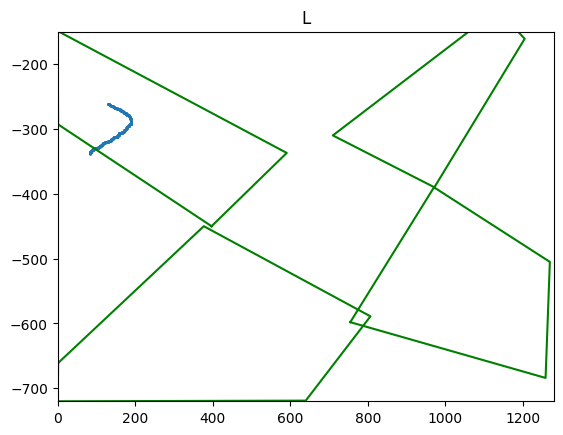

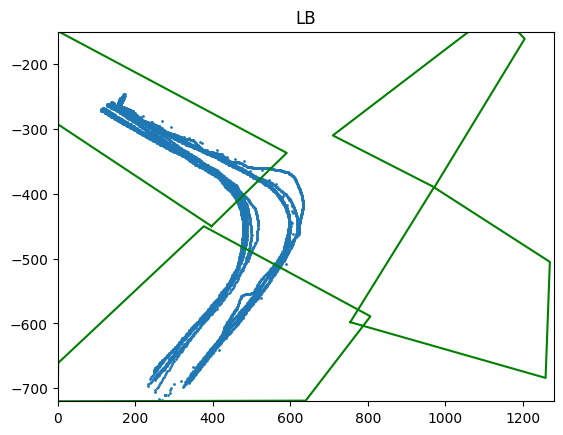

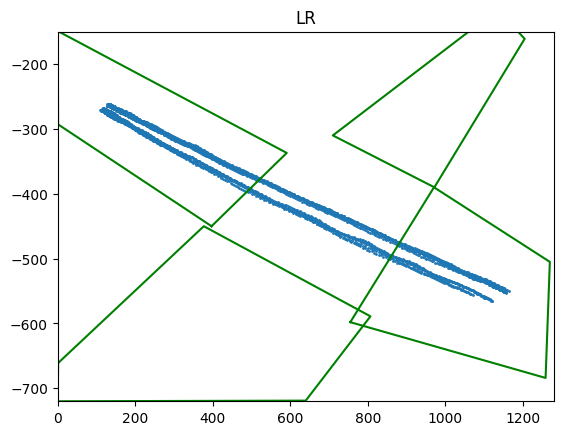

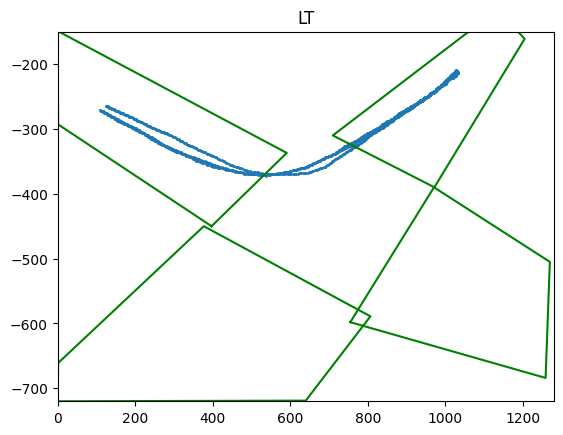

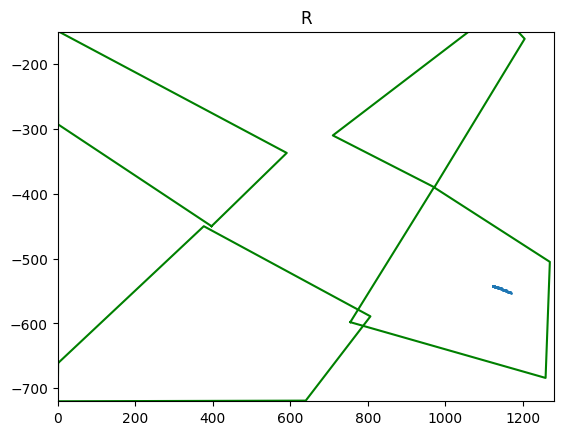

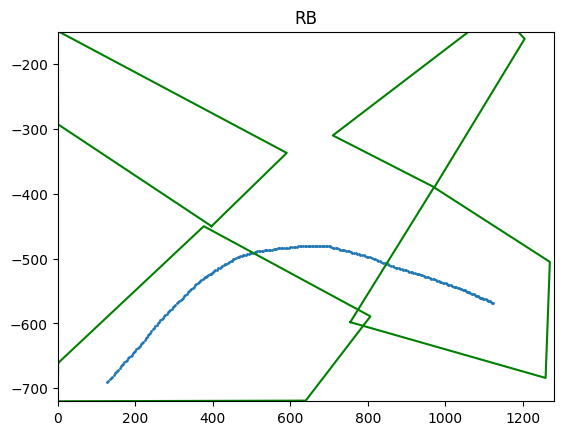

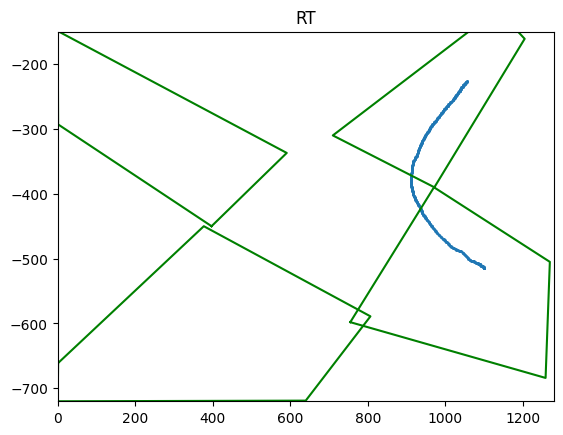

In [ ]:
for _path_type, _data  in true_points.groupby("path type"):
    check_path(_data)
    plt.title(_path_type)
    plt.show()

## Obliczenie metryk poprawności śledzenia

In [ ]:
#calculate if point is inside a bbox
#(the true points are not always perfectly on the car, so I use `eps` to be more forgiving)
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
match_x = ((matching["x0"] <= matching["x"]) & (matching["x"] <= matching["x1"] ))
match_y = ((matching["y0"] <= matching["y"]) & (matching["y"] <= matching["y1"]))
matching = matching[match_x & match_y]
matched = matching.copy().drop(columns=["x0","y0","x1", "y1"])

In [ ]:
point_count = true_points.groupby(["label","frame"]).count().reset_index()\
                         .groupby("label").count().reset_index() \
                         .drop(columns=["path type", "x", "y"]) \
                         .rename(columns={"frame":"point count"})
point_count.head(5)

,label,point count
0,0,2506
1,1,2564
2,2,1613
3,3,721
4,4,463


In [ ]:
# check if there are any objects with 2 bbox per frame
tracking_bbox.drop(columns = ["x0", "y0", "y1"]).groupby(["label", "frame"]).count()\
             .reset_index().rename(columns={"x1": "max bbox count per object per frame"}).max()

label                                   432
frame                                  3600
max bbox count per object per frame       1
dtype: int64

In [ ]:
bbox_count = tracking_bbox.groupby(["label"]).count().reset_index()[["label", "frame"]]\
                          .rename(columns={"frame": "bbox count"})
bbox_count.head(5)

,label,bbox count
0,308,437
1,309,1265
2,310,287
3,311,2511
4,312,660


In [ ]:
_tmp = true_points.groupby(["label", "frame"]).count()[["x"]].reset_index().rename(columns={"x": "count true"})
matches_count = matching.groupby(["label_true", "label_pred", "frame"]).count()[["x"]].rename(columns={"x":"count match"})\
              .reset_index().merge(_tmp, left_on=["label_true", "frame"], right_on=["label", "frame"])
matches_count["count"] = (matches_count["count match"]/matches_count["count true"])
matches_count = matches_count[["label_true", "label_pred", "count"]].groupby(["label_true", "label_pred"]).sum().reset_index()
matches_count = matches_count.rename(columns={"count": "matches count"})
matches_count.head(5)

,label_true,label_pred,matches count
0,0,311,2505.0
1,0,345,506.0
2,0,370,908.0
3,1,313,323.0
4,1,323,41.0


In [ ]:
IoU = matches_count.merge(point_count, left_on="label_true", right_on="label").drop(columns=["label"])
IoU = IoU.merge(bbox_count, left_on="label_pred", right_on="label").drop(columns=["label"])
IoU["IoU"] = IoU["matches count"]/(IoU["point count"] + IoU["bbox count"] - IoU["matches count"])
IoU[["label_true", "label_pred", "IoU"]].sort_values("IoU")

,label_true,label_pred,IoU
11,1,355,0.000243
81,21,356,0.000555
14,1,412,0.000780
15,20,412,0.001145
60,18,357,0.001565
...,...,...,...
98,29,371,0.937500
118,38,402,0.953947
87,23,358,0.995756
0,0,311,0.997213


*Code is based on https://github.com/JonathonLuiten/TrackEval/blob/master/trackeval/metrics/identity.py*

In [ ]:
def calculate_metrics(true_points, tracking_bbox, matched):
    num_gt_ids = len(true_points["label"].unique())
    num_tracker_ids = len(tracking_bbox["label"].unique())

    translate = pd.DataFrame(enumerate(tracking_bbox["label"].unique()), columns=["new_lebel_pred", "label_pred"])
    translate

    potential_matches_count = np.zeros((num_gt_ids, num_tracker_ids))
    _tmp = matched[["label_true", "label_pred", "frame"]].groupby(["label_true","label_pred"]).count().reset_index()\
           .merge(translate, on="label_pred").drop(columns="label_pred")
    for i, (label_true, match_count, label_pred) in _tmp.iterrows():
        potential_matches_count[label_true, label_pred] = match_count

    gt_id_count = np.zeros(num_gt_ids)
    tracker_id_count = np.zeros(num_tracker_ids)
    _tmp = true_points[["label", "frame"]].drop_duplicates().groupby("label").count().reset_index()
    for i, (gt_id, gt_count) in _tmp.iterrows():
        gt_id_count[gt_id] = gt_count
    _tmp = tracking_bbox[["label", "frame"]].groupby("label").count().reset_index()\
                      .merge(translate, left_on="label", right_on="label_pred").drop(columns=["label", "label_pred"])
    for i, (tracker_count, tracker_id) in _tmp.iterrows():
        tracker_id_count[tracker_id] = tracker_count

    from scipy.optimize import linear_sum_assignment

    res = {}

    fp_mat = np.zeros((num_gt_ids + num_tracker_ids, num_gt_ids + num_tracker_ids))
    fn_mat = np.zeros((num_gt_ids + num_tracker_ids, num_gt_ids + num_tracker_ids))
    fp_mat[num_gt_ids:, :num_tracker_ids] = 1e10
    fn_mat[:num_gt_ids, num_tracker_ids:] = 1e10
    for gt_id in range(num_gt_ids):
        fn_mat[gt_id, :num_tracker_ids] = gt_id_count[gt_id]
        fn_mat[gt_id, num_tracker_ids + gt_id] = gt_id_count[gt_id]
    for tracker_id in range(num_tracker_ids):
        fp_mat[:num_gt_ids, tracker_id] = tracker_id_count[tracker_id]
        fp_mat[tracker_id + num_gt_ids, tracker_id] = tracker_id_count[tracker_id]
    fn_mat[:num_gt_ids, :num_tracker_ids] -= potential_matches_count
    fp_mat[:num_gt_ids, :num_tracker_ids] -= potential_matches_count

    # Hungarian algorithm
    match_rows, match_cols = linear_sum_assignment(fn_mat + fp_mat)

    # Accumulate basic statistics
    res['IDFN'] = fn_mat[match_rows, match_cols].sum().astype(int)
    res['IDFP'] = fp_mat[match_rows, match_cols].sum().astype(int)
    res['IDTP'] = (gt_id_count.sum() - res['IDFN']).astype(int)

    res['IDR'] = res['IDTP'] / np.maximum(1.0, res['IDTP'] + res['IDFN'])
    res['IDP'] = res['IDTP'] / np.maximum(1.0, res['IDTP'] + res['IDFP'])
    res['IDF1'] = res['IDTP'] / np.maximum(1.0, res['IDTP'] + 0.5 * res['IDFP'] + 0.5 * res['IDFN'])
    return res
res = calculate_metrics(true_points, tracking_bbox, matched)
print(f"Identification Precision: {res['IDP']*100:.4}%")
print(f"Identification Recall: {res['IDR']*100:.4}%")
print(f"Identification F1: {res['IDF1']*100:.4}%")

Identification Precision: 69.49%
Identification Recall: 68.34%
Identification F1: 68.91%


In [ ]:
#calculate if point is inside a bbox
#(the true points are not always perfectly on the car, so I use `eps` to be more forgiving)
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
match_x = ((matching["x0"] <= matching["x"]) & (matching["x"] <= matching["x1"] ))
match_y = ((matching["y0"] <= matching["y"]) & (matching["y"] <= matching["y1"]))
matching = matching[match_x & match_y]
matched = matching.copy().drop(columns=["x0","y0","x1", "y1"])

Definicje metryk:
 * `(%) matches best` - jaka część punktów pojazdu została przydzielona do obiektu (ze śledzenia), przy czym wybieramy obiekt dla któego ta część jak największa. Metryka powinna być jak największa, ale nie musi być 100%, bo brak detekcji samochodu również ma na nią wpływ.
 * `(%) matches 2nd best` - tak samo jak wyżej, tylko biorę drugi najlepszy obiekt. Metryka powinny być jak najmniejsza. Brak detekcji samochodu nie wypływa negatywnie na metrykę.
 * `(%) nondominant matches` -  podobnie jak `(%) matches best` tylko sumuje metryki dla wszystkich obiektów innych niż najlepszy (tzn. inne niż te używane w `(%) matches best`).

In [ ]:
def check_true_object_i(label_i):
    points_count = true_points["label"].value_counts()[label_i]
    time_matched = matched[matched["label_true"]== label_i]["label_pred"].value_counts()/points_count*100
    remaining = 0
    if len(time_matched) > 0:
        remaining = time_matched.sum() - float(time_matched.head(1))
    time_matched = time_matched.head(2)
    return (list(time_matched) + [0, 0])[:2] + [remaining]
object_metrics = pd.DataFrame([check_true_object_i(y) + [y]
                           for y in true_points["label"].unique()],
            columns = ["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches", "true_object_id"])
object_metrics = pd.merge(object_metrics, directions, left_on="true_object_id", right_on="label")
object_metrics = object_metrics.drop(columns =["label"])
object_metrics.head(5)


,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id,path type
0,99.960112,36.218588,56.402074,0,BT
1,82.761310,12.597504,14.313573,1,BT
2,78.425294,7.873528,8.183509,2,RT
3,49.058971,29.485571,34.127980,3,LB
4,39.092873,19.438445,35.205184,4,LB


In [ ]:
object_metrics

,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id,path type
0,99.960112,36.218588,56.402074,0,BT
1,82.761310,12.597504,14.313573,1,BT
2,78.425294,7.873528,8.183509,2,RT
3,49.058971,29.485571,34.127980,3,LB
4,39.092873,19.438445,35.205184,4,LB
5,53.786408,34.174757,34.563107,5,LB
6,30.983847,0.587372,0.587372,6,LR
7,53.091684,38.720682,84.392324,7,BT
8,69.788520,38.066465,39.879154,8,LB
9,96.358543,5.882353,7.843137,9,LB


In [ ]:
object_metrics.drop(columns="path type").mean()

(%) matches best           69.412620
(%) matches 2nd best       12.527411
(%) nondominant matches    16.760979
true_object_id             23.000000
dtype: float64

In [ ]:
sorted_groups = sorted(object_metrics.groupby("path type"), key=lambda x: len(x[1]), reverse=True)
for _path_type, _data in sorted_groups:
    print(_path_type, f" count {len(_data)}")
    display(_data.drop(columns="path type").mean())
    print("\n")

BT  count 16


(%) matches best           67.731733
(%) matches 2nd best       13.398043
(%) nondominant matches    20.550174
true_object_id             27.687500
dtype: float64



LB  count 12


(%) matches best           68.931733
(%) matches 2nd best       16.307749
(%) nondominant matches    19.359843
true_object_id             10.083333
dtype: float64



LR  count 9


(%) matches best           68.214046
(%) matches 2nd best       10.758471
(%) nondominant matches    13.000956
true_object_id             26.555556
dtype: float64



B  count 3


(%) matches best           100.000000
(%) matches 2nd best         9.109034
(%) nondominant matches      9.109034
true_object_id              29.333333
dtype: float64



LT  count 3


(%) matches best           33.473563
(%) matches 2nd best       12.585769
(%) nondominant matches    21.293301
true_object_id             29.666667
dtype: float64



L  count 1


(%) matches best           63.687151
(%) matches 2nd best        6.145251
(%) nondominant matches     7.448790
true_object_id             32.000000
dtype: float64



R  count 1


(%) matches best           95.394737
(%) matches 2nd best        0.000000
(%) nondominant matches     0.000000
true_object_id             38.000000
dtype: float64



RB  count 1


(%) matches best           99.650350
(%) matches 2nd best        2.797203
(%) nondominant matches     2.797203
true_object_id             29.000000
dtype: float64



RT  count 1


(%) matches best           78.425294
(%) matches 2nd best        7.873528
(%) nondominant matches     8.183509
true_object_id              2.000000
dtype: float64

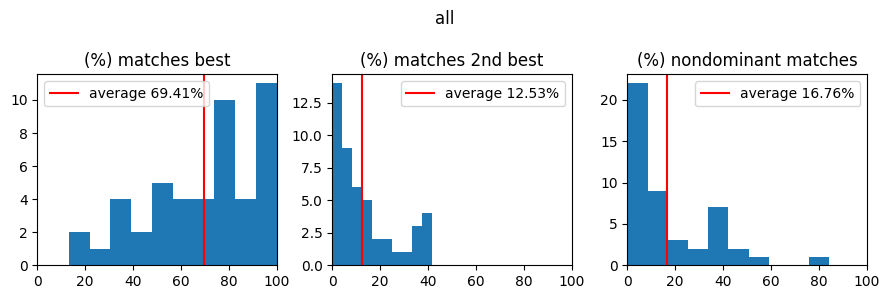

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(9,3))

fig.suptitle("all")
for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
    axs[i].hist(object_metrics[col])
    avg =object_metrics[col].mean()
    axs[i].set_title(col)
    axs[i].axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
    axs[i].set_xlim(0, 100)
    axs[i].legend()
plt.tight_layout()
plt.show()

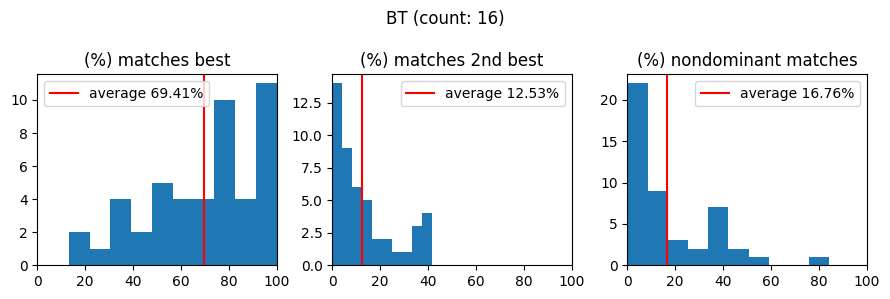

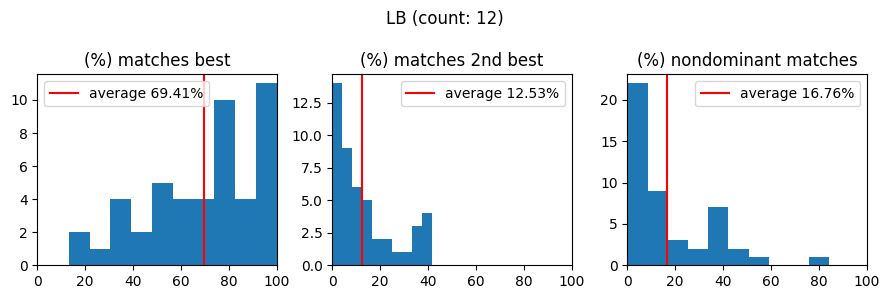

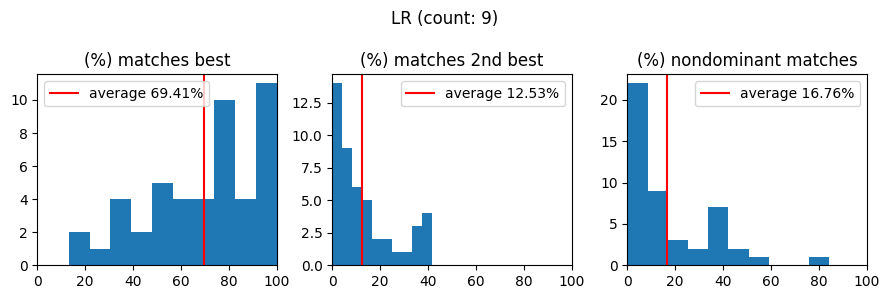

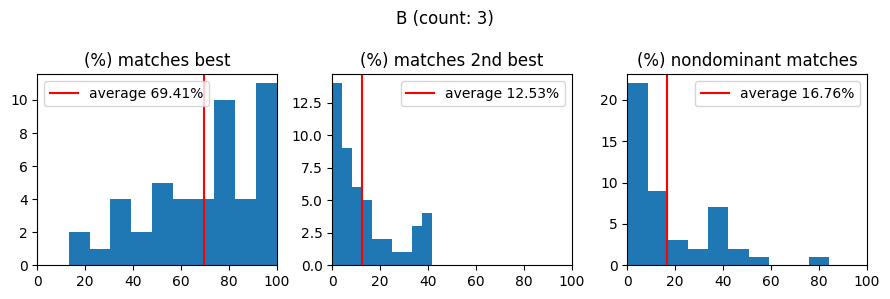

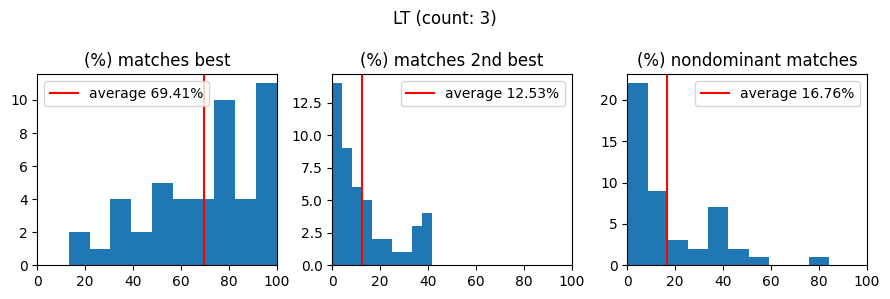

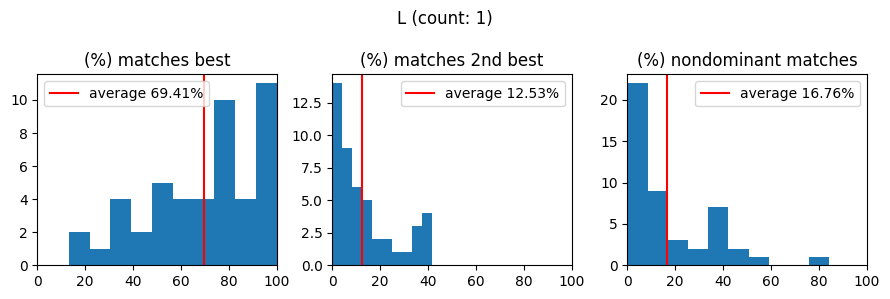

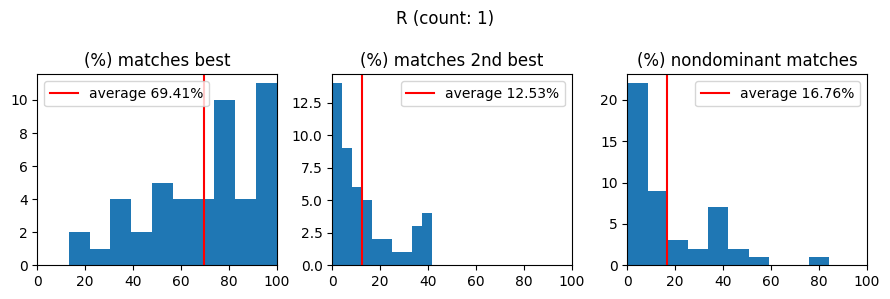

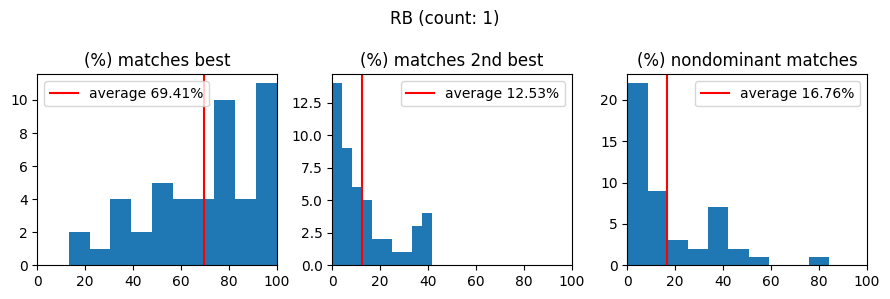

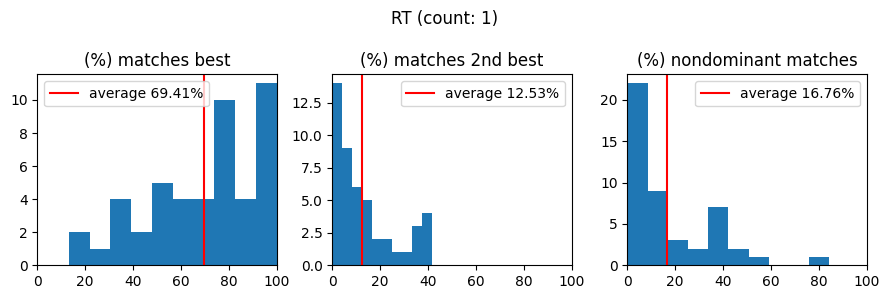

In [ ]:
sorted_groups = sorted(object_metrics.groupby("path type"), key=lambda x: len(x[1]), reverse=True)
for _path_type, _data in sorted_groups:
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    fig.suptitle(_path_type + f" (count: {len(_data)})")
    for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
        axs[i].hist(object_metrics[col])
        avg =object_metrics[col].mean()
        axs[i].set_title(col)
        axs[i].axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
        axs[i].set_xlim(0, 100)
        axs[i].legend()
    plt.tight_layout()
    plt.show()

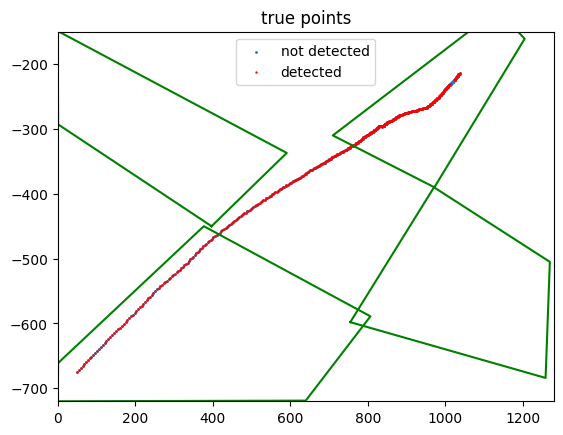

In [ ]:

def check(tp, match):
    plt.title("true points")
    plt.scatter(tp["x"], (-1)*tp["y"], s=1, label="not detected")
    plt.scatter(match["x"], (-1)*match["y"], s=0.5, color="red", label="detected")
    for polygon in [left_area, right_area, bottom_area, top_area]:
        area = np.array(polygon + [polygon[0]])
        plt.plot(area[:, 0], -area[:, 1], color="green")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)
    plt.legend()
#check(true_points, matching)

check(true_points[true_points["label"] == 7],
      matching[matching["label_true"] == 7])